# Feature selection

<a id="importing"></a>
## Importing libraries and packages

In [1]:
# Warnings
import warnings

# Mathematical operations and data manipulation
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.impute import SimpleImputer

# https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html
from sklearn.experimental import enable_iterative_imputer  # noqa

# Didn't work, so I added IterativeImputer to the _all_ list in
# sklearn impute by hand
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso

# For loading .arff files
from scipy.io import arff

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

<a id="set-paths"></a>
## Set paths

In [2]:
# Path to datasets directory
data_path = "./datasets"
# Path to assets directory (for saving results to)
assets_path = "./assets"

<a id="loading-data"></a>
## Loading dataset

In [3]:
# Loading the 5 raw .arff files into a list
def load_arff_raw_data():
    n = 5
    return [
        arff.loadarff(f"{data_path}/" + str(i + 1) + "year.arff")
        for i in range(n)
    ]


# Loading the 5 raw .arff files into pandas dataframes
def load_dataframes():
    return [
        pd.DataFrame(data_i_year[0]) for data_i_year in load_arff_raw_data()
    ]


# Setting column headers from X1 ... X64 and the class label as Y,
# for all the 5 dataframes.
def set_new_headers(dataframes):
    cols = ["X" + str(i + 1) for i in range(len(dataframes[0].columns) - 1)]
    cols.append("Y")
    for df in dataframes:
        df.columns = cols


# dataframes is the list of pandas dataframes for the 5 year datafiles.
dfs = load_dataframes()

# Set new headers for the dataframes: the renamed set of feature (X1 to X64)
set_new_headers(dfs)

# print the first 5 rows of a dataset 'year1'
dfs[0].head()

X1       X2       X3      X4       X5       X6        X7       X8  \
0  0.200550  0.37951  0.39641  2.0472  32.3510  0.38825  0.249760  1.33050   
1  0.209120  0.49988  0.47225  1.9447  14.7860  0.00000  0.258340  0.99601   
2  0.248660  0.69592  0.26713  1.5548  -1.1523  0.00000  0.309060  0.43695   
3  0.081483  0.30734  0.45879  2.4928  51.9520  0.14988  0.092704  1.86610   
4  0.187320  0.61323  0.22960  1.4063  -7.3128  0.18732  0.187320  0.63070   

       X9      X10  ...       X56      X57      X58       X59     X60     X61  \
0  1.1389  0.50494  ...  0.121960  0.39718  0.87804  0.001924  8.4160  5.1372   
1  1.6996  0.49788  ...  0.121300  0.42002  0.85300  0.000000  4.1486  3.2732   
2  1.3090  0.30408  ...  0.241140  0.81774  0.76599  0.694840  4.9909  3.9510   
3  1.0571  0.57353  ...  0.054015  0.14207  0.94598  0.000000  4.5746  3.6147   
4  1.1559  0.38677  ...  0.134850  0.48431  0.86515  0.124440  6.3985  4.3158   

       X62     X63      X64     Y  
0   82.658  4.4158   7.4277  b'0'  
1  107.350  3.4000  60.9870  b'0'  
2  134.270  2.7185   5.2078  b'0'  
3   86.435  4.2228   5.5497  b'0'  
4  127.210  2.8692   7.8980  b'0'  

[5 rows x 65 columns]

In [4]:
dfs[0].shape

(7027, 65)

In [5]:
# Converting dtypes of all the columns (other than the class
# label columns) to float.
def convert_columns_type_float(dataframes):
    for i in range(5):
        index = 1
        while index <= 63:
            colname = dfs[i].columns[index]
            col = getattr(dfs[i], colname)
            dataframes[i][colname] = col.astype(float)
            index += 1


convert_columns_type_float(dfs)

In [6]:
# The class labels for all the dataframes are originally in object type.
# Converting to int types
def convert_class_label_type_int(dataframes):
    for i in range(len(dataframes)):
        col = getattr(dfs[i], "Y")
        dataframes[i]["Y"] = col.astype(int)


convert_class_label_type_int(dfs)

In [7]:
# Shape of the year1 DataFrame
dfs[0].head()

X1       X2       X3      X4       X5       X6        X7       X8  \
0  0.200550  0.37951  0.39641  2.0472  32.3510  0.38825  0.249760  1.33050   
1  0.209120  0.49988  0.47225  1.9447  14.7860  0.00000  0.258340  0.99601   
2  0.248660  0.69592  0.26713  1.5548  -1.1523  0.00000  0.309060  0.43695   
3  0.081483  0.30734  0.45879  2.4928  51.9520  0.14988  0.092704  1.86610   
4  0.187320  0.61323  0.22960  1.4063  -7.3128  0.18732  0.187320  0.63070   

       X9      X10  ...       X56      X57      X58       X59     X60     X61  \
0  1.1389  0.50494  ...  0.121960  0.39718  0.87804  0.001924  8.4160  5.1372   
1  1.6996  0.49788  ...  0.121300  0.42002  0.85300  0.000000  4.1486  3.2732   
2  1.3090  0.30408  ...  0.241140  0.81774  0.76599  0.694840  4.9909  3.9510   
3  1.0571  0.57353  ...  0.054015  0.14207  0.94598  0.000000  4.5746  3.6147   
4  1.1559  0.38677  ...  0.134850  0.48431  0.86515  0.124440  6.3985  4.3158   

       X62     X63      X64  Y  
0   82.658  4.4158   7.4277  0  
1  107.350  3.4000  60.9870  0  
2  134.270  2.7185   5.2078  0  
3   86.435  4.2228   5.5497  0  
4  127.210  2.8692   7.8980  0  

[5 rows x 65 columns]

X1 net profit / total assets
X2 total liabilities / total assets
X3 working capital / total assets
X4 current assets / short-term liabilities
X5 ((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365
X6 retained earnings / total assets
X7 EBIT / total assets
X8 book value of equity / total liabilities
X9 sales / total assets
X10 equity / total assets
X11 (gross profit + extraordinary items + financial expenses) / total assets
X12 gross profit / short-term liabilities
X13 (gross profit + depreciation) / sales
X14 (gross profit + interest) / total assets
X15 (total liabilities * 365) / (gross profit + depreciation)
X16 (gross profit + depreciation) / total liabilities
X17 total assets / total liabilities
X18 gross profit / total assets
X19 gross profit / sales
X20 (inventory * 365) / sales
X21 sales (n) / sales (n-1)
X22 profit on operating activities / total assets
X23 net profit / sales
X24 gross profit (in 3 years) / total assets
X25 (equity - share capital) / total assets
X26 (net profit + depreciation) / total liabilities
X27 profit on operating activities / financial expenses
X28 working capital / fixed assets
X29 logarithm of total assets
X30 (total liabilities - cash) / sales
X31 (gross profit + interest) / sales
X32 (current liabilities * 365) / cost of products sold
X33 operating expenses / short-term liabilities
X34 operating expenses / total liabilities
X35 profit on sales / total assets
X36 total sales / total assets
X37 (current assets - inventories) / long-term liabilities
X38 constant capital / total assets
X39 profit on sales / sales
X40 (current assets - inventory - receivables) / short-term liabilities
X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))
X42 profit on operating activities / sales
X43 rotation receivables + inventory turnover in days
X44 (receivables * 365) / sales
X45 net profit / inventory
X46 (current assets - inventory) / short-term liabilities
X47 (inventory * 365) / cost of products sold
X48 EBITDA (profit on operating activities - depreciation) / total assets
X49 EBITDA (profit on operating activities - depreciation) / sales
X50 current assets / total liabilities
X51 short-term liabilities / total assets
X52 (short-term liabilities * 365) / cost of products sold)
X53 equity / fixed assets
X54 constant capital / fixed assets
X55 working capital
X56 (sales - cost of products sold) / sales
X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
X58 total costs /total sales
X59 long-term liabilities / equity
X60 sales / inventory
X61 sales / receivables
X62 (short-term liabilities *365) / sales
X63 sales / short-term liabilities
X64 sales / fixed assets

<a id="missing"></a>
## Missing Value Analysis for the DataFrames

<AxesSubplot:>

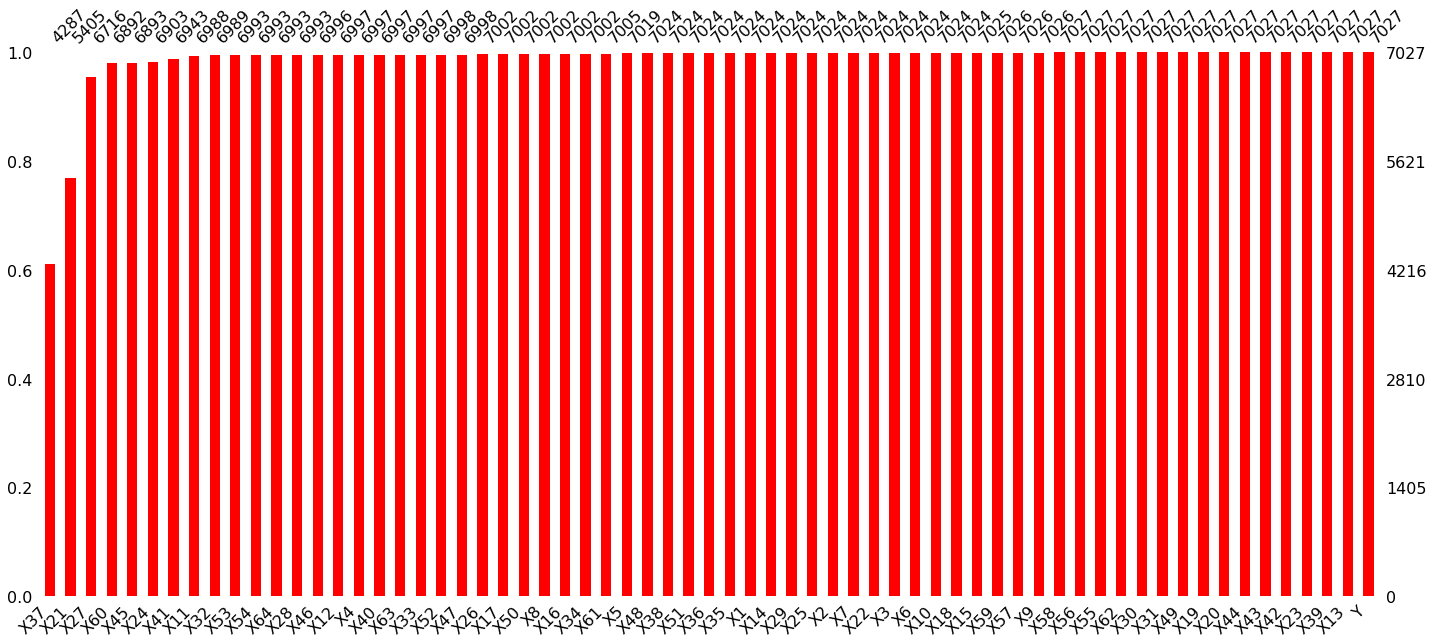

In [8]:
# Missing Values in the first Dataframe
msno.bar(dfs[0], color="red", labels=True, sort="ascending")

<AxesSubplot:>

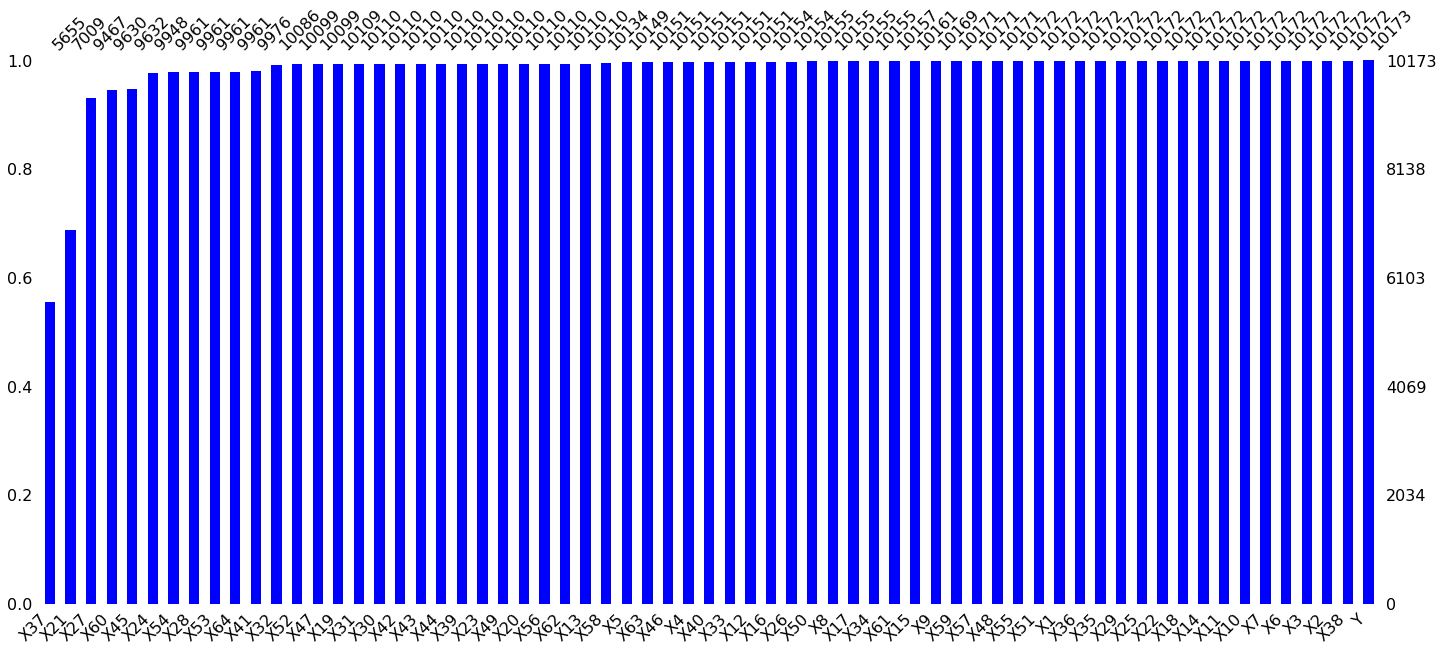

In [9]:
# Missing Values in the second Dataframe
msno.bar(dfs[1], color="blue", labels=True, sort="ascending")

<AxesSubplot:>

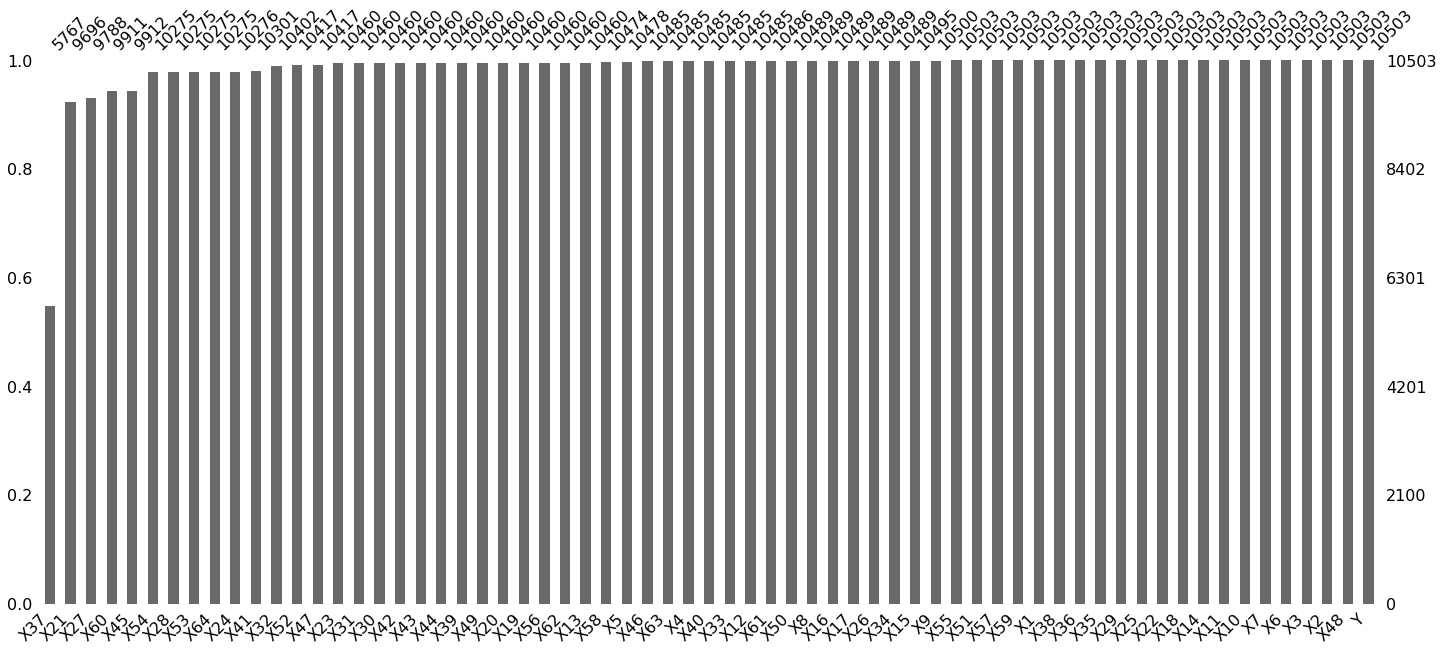

In [10]:
# Missing Values in the third Dataframe
msno.bar(dfs[2], labels=True, sort="ascending")

<a id="mean-imputation"></a>
## Mean Imputation on the DataFrames

In [11]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")

<AxesSubplot:>

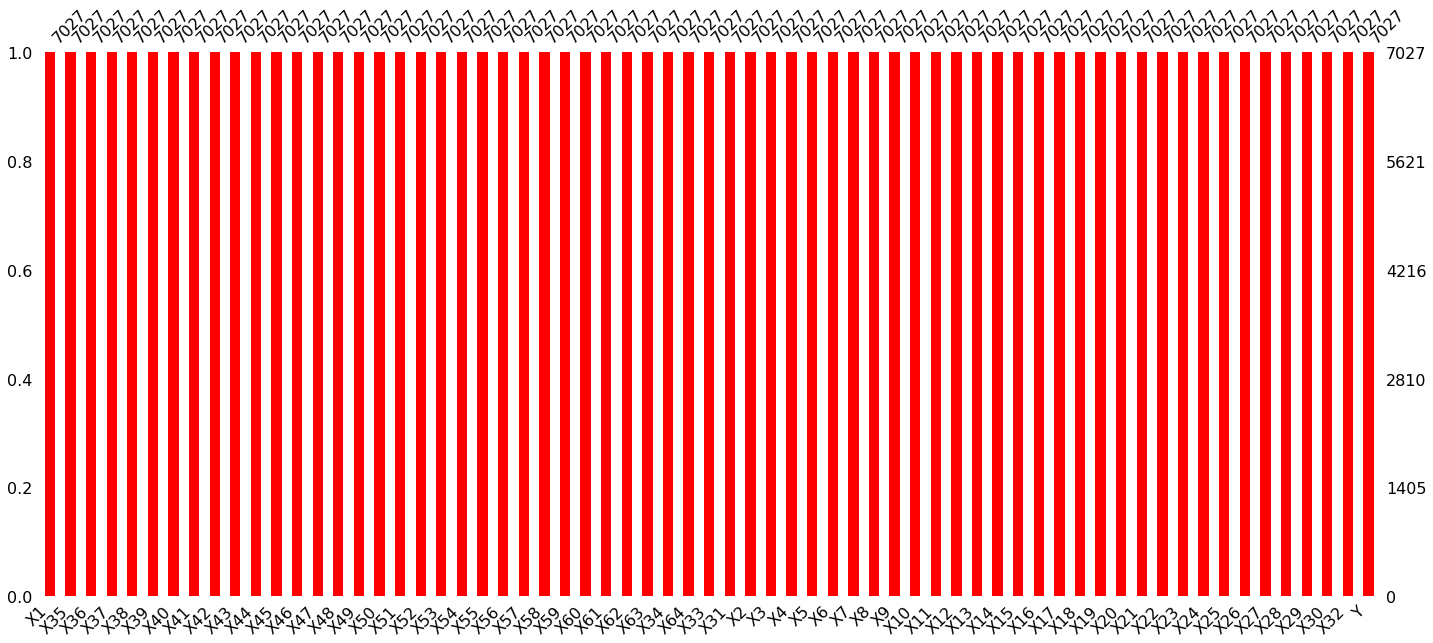

In [12]:
# Imputation for the first Dataframe
mean_imputed_df1 = pd.DataFrame(
    imputer.fit_transform(dfs[0]), columns=dfs[0].columns
)

# Checking for missing values
msno.bar(mean_imputed_df1, color="red", labels=True, sort="ascending")

<AxesSubplot:>

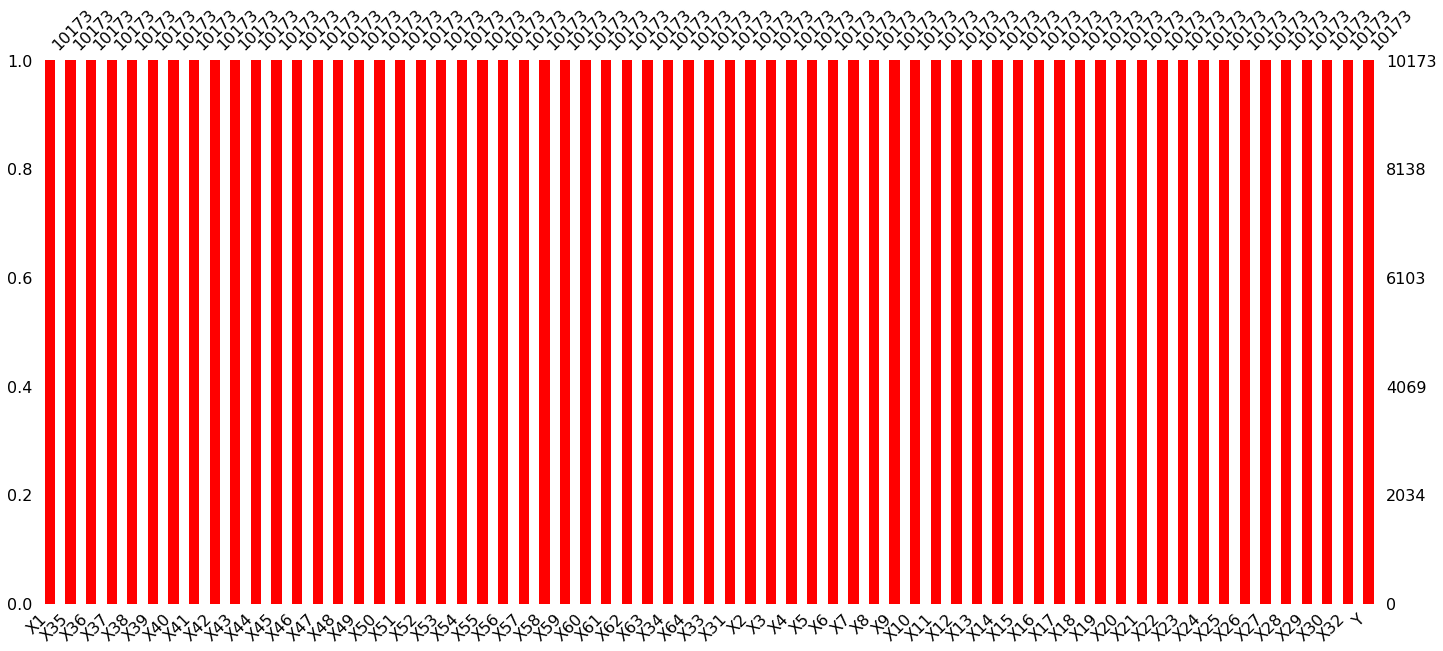

In [13]:
# Imputation for the second Dataframe
mean_imputed_df2 = pd.DataFrame(
    imputer.fit_transform(dfs[1]), columns=dfs[1].columns
)

# Checking for missing values
msno.bar(mean_imputed_df2, color="red", labels=True, sort="ascending")

<AxesSubplot:>

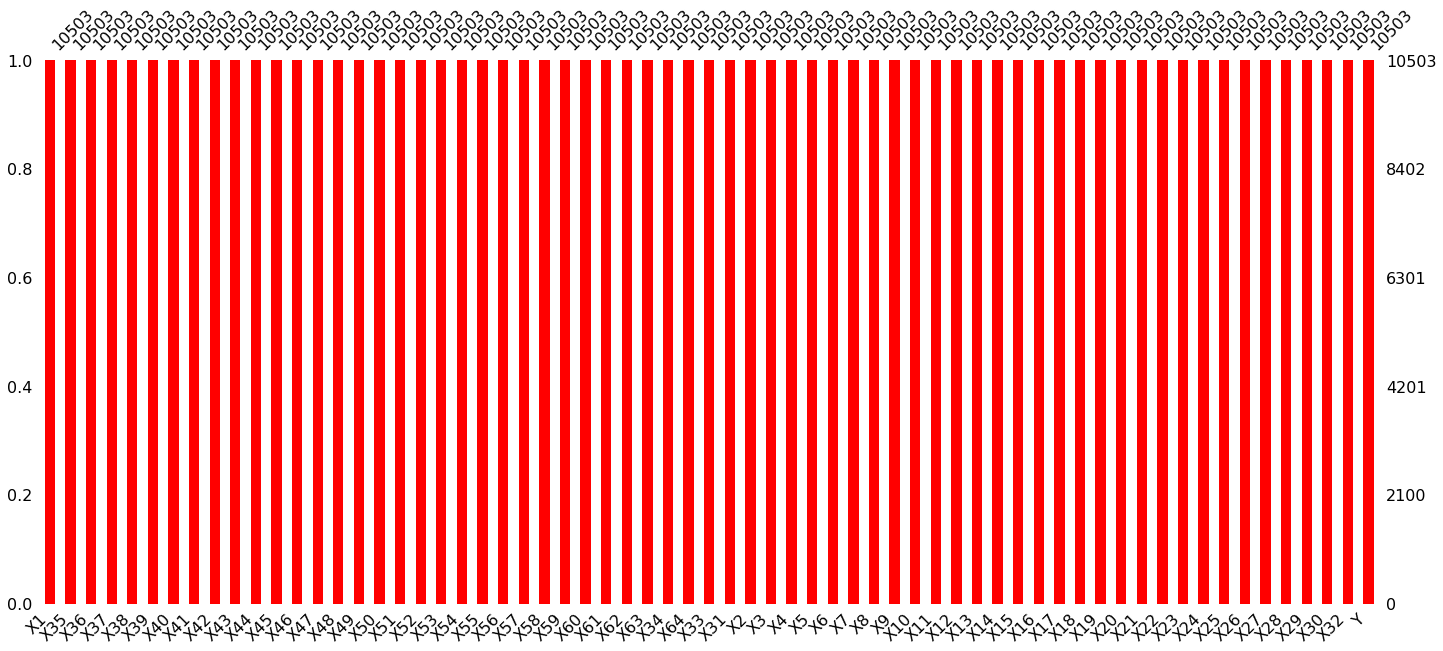

In [14]:
# Imputation for the third  Dataframe
mean_imputed_df3 = pd.DataFrame(
    imputer.fit_transform(dfs[2]), columns=dfs[2].columns
)

# Checking missing values
msno.bar(mean_imputed_df3, color="red", labels=True, sort="ascending")

In [15]:
# Imputation for the fourth Dataframe
mean_imputed_df4 = pd.DataFrame(
    imputer.fit_transform(dfs[3]), columns=dfs[3].columns
)
# Imputation for the fifth Dataframe
mean_imputed_df5 = pd.DataFrame(
    imputer.fit_transform(dfs[4]), columns=dfs[4].columns
)

<a id="iterative-imputation"></a>
## Iterative Imputation on the DataFrames

In [16]:
imputer = IterativeImputer()

<AxesSubplot:>

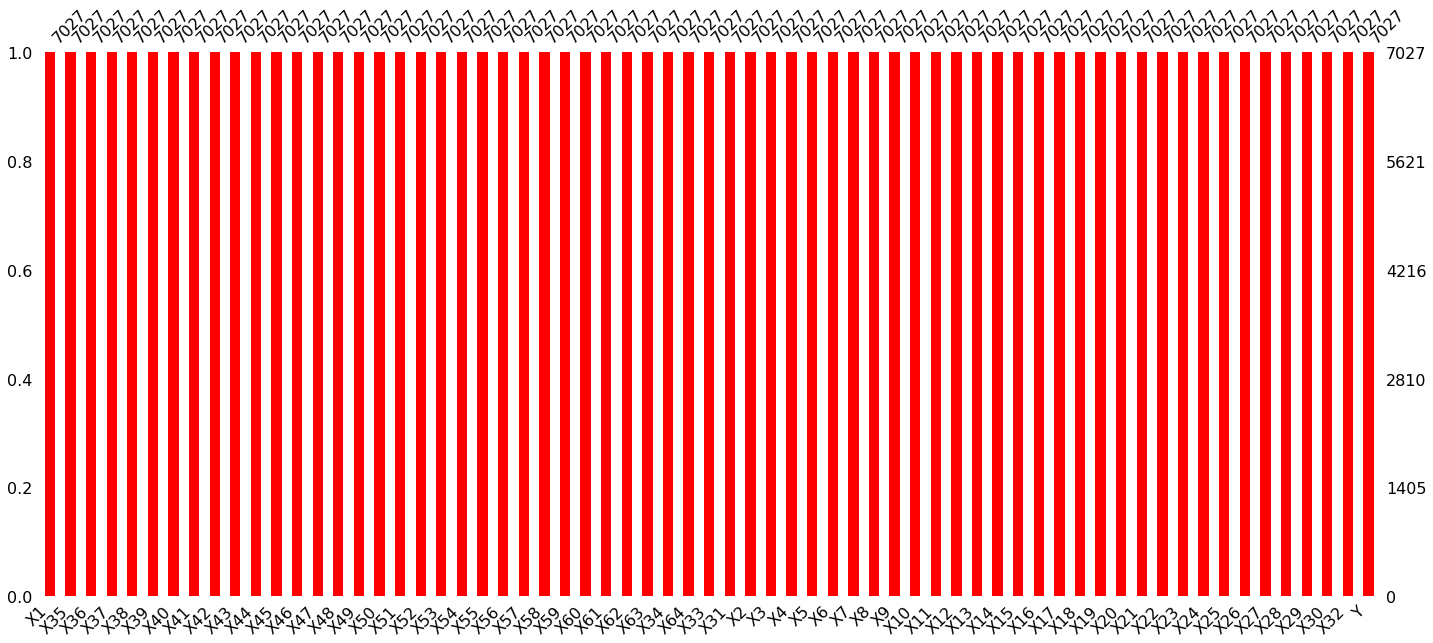

In [17]:
# First DataFrame
iterative_imputed_df1 = pd.DataFrame(
    imputer.fit_transform(dfs[0]), columns=dfs[0].columns
)

# Checking missing values
msno.bar(iterative_imputed_df1, color="red", labels=True, sort="ascending")

<AxesSubplot:>

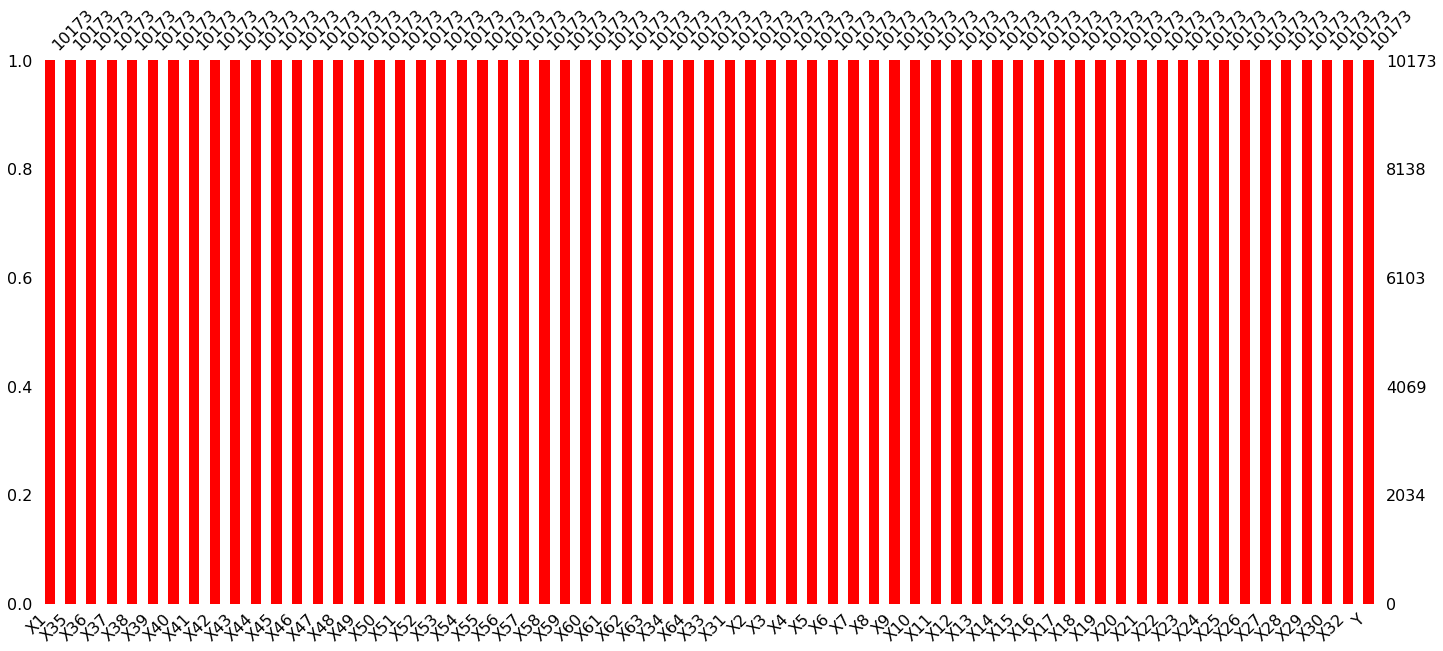

In [18]:
# Second DataFrame
iterative_imputed_df2 = pd.DataFrame(
    imputer.fit_transform(dfs[1]), columns=dfs[1].columns
)

# Checking missing values
msno.bar(iterative_imputed_df2, color="red", labels=True, sort="ascending")

Etcetera

In [19]:
# Third DataFrame
iterative_imputed_df3 = pd.DataFrame(
    imputer.fit_transform(dfs[2]), columns=dfs[2].columns
)
# Fourth DataFrame
iterative_imputed_df4 = pd.DataFrame(
    imputer.fit_transform(dfs[3]), columns=dfs[3].columns
)
# Fifth DataFrame
iterative_imputed_df5 = pd.DataFrame(
    imputer.fit_transform(dfs[4]), columns=dfs[4].columns
)

<a id="splitting"></a>
## Splitting the features

In [20]:
# First DataFrame
X0 = mean_imputed_df1.drop("Y", axis=1)
y0 = mean_imputed_df1.Y
# Second DataFrame
X1 = mean_imputed_df2.drop("Y", axis=1)
y1 = mean_imputed_df2.Y
# Third DataFrame
X2 = mean_imputed_df3.drop("Y", axis=1)
y2 = mean_imputed_df3.Y
X6 = mean_imputed_df4.drop("Y", axis=1)
y6 = mean_imputed_df4.Y
X7 = mean_imputed_df5.drop("Y", axis=1)
y7 = mean_imputed_df5.Y

In [21]:
# First DataFrame
X3 = iterative_imputed_df1.drop("Y", axis=1)
y3 = iterative_imputed_df1.Y
# Second DataFrame
X4 = iterative_imputed_df2.drop("Y", axis=1)
y4 = iterative_imputed_df2.Y
# Third DataFrame
X5 = iterative_imputed_df3.drop("Y", axis=1)
y5 = iterative_imputed_df3.Y
X8 = iterative_imputed_df4.drop("Y", axis=1)
y8 = iterative_imputed_df4.Y
X9 = iterative_imputed_df5.drop("Y", axis=1)
y9 = iterative_imputed_df5.Y

<a id="selection"></a>
## Feature Selection with Lasso

In [22]:
features_names = X6.columns.tolist()
lasso = Lasso(alpha=0.01, positive=True)
lasso.fit(X6, y6)
coef_list = sorted(
    zip(map(lambda x: round(x, 4), lasso.coef_.reshape(-1)), features_names),
    reverse=True,
)
coef_list[0:5]

[(0.0009, 'X21'), (0.0002, 'X2'), (0.0001, 'X42'), (0.0, 'X9'), (0.0, 'X8')]

In [23]:
features_names = X7.columns.tolist()
lasso = Lasso(alpha=0.01, positive=True)
lasso.fit(X7, y7)
coef_list = sorted(
    zip(map(lambda x: round(x, 4), lasso.coef_.reshape(-1)), features_names),
    reverse=True,
)
coef_list[0:10]

[(0.0216, 'X51'),
 (0.0015, 'X2'),
 (0.001, 'X9'),
 (0.001, 'X36'),
 (0.0003, 'X59'),
 (0.0003, 'X52'),
 (0.0001, 'X61'),
 (0.0001, 'X31'),
 (0.0001, 'X30'),
 (0.0001, 'X20')]

In [24]:
features_names = X8.columns.tolist()
lasso = Lasso(alpha=0.01, positive=True)
lasso.fit(X8, y8)
coef_list = sorted(
    zip(map(lambda x: round(x, 4), lasso.coef_.reshape(-1)), features_names),
    reverse=True,
)
coef_list[0:5]

[(0.0009, 'X21'), (0.0002, 'X42'), (0.0002, 'X2'), (0.0, 'X9'), (0.0, 'X8')]

In [25]:
features_names = X9.columns.tolist()
lasso = Lasso(alpha=0.01, positive=True)
lasso.fit(X9, y9)
coef_list = sorted(
    zip(map(lambda x: round(x, 4), lasso.coef_.reshape(-1)), features_names),
    reverse=True,
)
coef_list[0:10]

[(0.0214, 'X51'),
 (0.0015, 'X2'),
 (0.0012, 'X9'),
 (0.0009, 'X36'),
 (0.0003, 'X59'),
 (0.0003, 'X52'),
 (0.0001, 'X61'),
 (0.0001, 'X31'),
 (0.0001, 'X30'),
 (0.0001, 'X20')]

The significant columns:
- X51 : Short-term liabilities/total assets
- X2 : Total liabilities/total assets
- X9 : Sales/total assets
- X36 : Total sales/total assets
- X59 : Long-term liabilities/equity
- X52 : (short-term liabilities * 365)/cost of products sold
- X61 : Sales/receivables
- X31 : (gross profit + interest)/sales
- X30 : (total liabilities - cash)/sales
- X20 : (inventory * 365)/sales